Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347
[001/100] 32.37 sec(s) Train Acc: 0.277620 Loss: 0.032467 | Val Acc: 0.344606 loss: 0.030582
[002/100] 22.85 sec(s) Train Acc: 0.369856 Loss: 0.028320 | Val Acc: 0.362391 loss: 0.028234
[003/100] 22.86 sec(s) Train Acc: 0.409183 Loss: 0.026392 | Val Acc: 0.371429 loss: 0.027164
[004/100] 23.02 sec(s) Train Acc: 0.448105 Loss: 0.025026 | Val Acc: 0.397376 loss: 0.026513
[005/100] 24.62 sec(s) Train Acc: 0.469390 Loss: 0.023955 | Val Acc: 0.447813 loss: 0.025311
[006/100] 24.81 sec(s) Train Acc: 0.494425 Loss: 0.022997 | Val Acc: 0.474344 loss: 0.023830
[007/100] 24.27 sec(s) Train Acc: 0.514900 Loss: 0.021986 | Val Acc: 0.545773 loss: 0.021296
[008/100] 23.37 sec(s) Train Acc: 0.540138 Loss: 0.021063 | Val Acc: 0.548980 loss: 0.021428
[009/100] 23.47 sec(s) Train Acc: 0.555848 Loss: 0.020284 | Val Acc: 0.539359 loss: 0.021410
[010/100] 23.41 sec(s) Train Acc: 0.567403 Loss: 0.019592 | Va

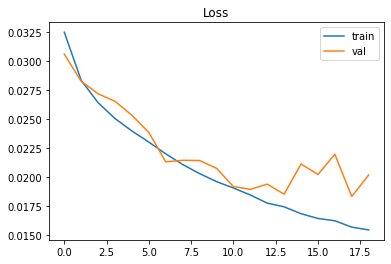

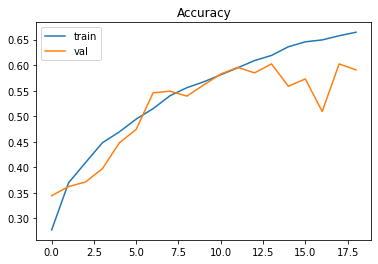

In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import random
import matplotlib.pyplot as plt  # 画图

# 定义一个读取图片的函数readfile()
def readfile(path, label):
    # label 是一个布尔值，代表需不需要返回 y 值
    image_dir = sorted(os.listdir(path))
    # x存储图片，每张彩色图片都是128(高)*128(宽)*3(彩色三通道)
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    # y存储标签，每个y大小为1
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        # 利用cv2.resize()函数将不同大小的图片统一为128(高)*128(宽)
        x[i, :, :] = cv2.resize(img, (128, 128))
        if label:
            y[i] = int(file.split("_")[0])
    if label:
        return x, y
    else:
        return x


# 分别将 training set、validation set、testing set 用函数 readfile() 读进来
workspace_dir = "./food-11"
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

# training 时，通过随机旋转、水平翻转图片来进行数据增强（data augmentation）
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),  # 随机翻转图片
        transforms.RandomRotation(15),  # 随机旋转图片
        transforms.ToTensor(),  # 将图片变成 Tensor，并且把数值normalize到[0,1]
    ]
)

# testing 时，不需要进行数据增强（data augmentation）
test_transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(),])


class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label 需要是 LongTensor 型
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X


# 定义残差块
class Residual_Block(nn.Module):
    def __init__(self, i_channel, o_channel, stride=1, down_sample=None):
        super(Residual_Block, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=i_channel,
            out_channels=o_channel,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        # BatchNorm2d(）对小批量3d数据组成的4d输入进行批标准化操作
        # 主要为了防止神经网络退化
        self.bn1 = nn.BatchNorm2d(o_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            in_channels=o_channel,
            out_channels=o_channel,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(o_channel)
        self.down_sample = down_sample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # 将单元的输入直接与单元输出加在一起
        if self.down_sample:
            residual = self.down_sample(x)  # 下采样
        out += residual
        out = self.relu(out)

        return out


# 定义残差神经网络
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=11):
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.in_channels = 16
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # dropout

    def make_layer(self, block, out_channels, blocks, stride=1):
        # blocks=layers,残差模块的数量
        down_sample = None
        # 判断是否in_channels(输入)与(输出)是否在同一维度
        # 即输入的3d数据的长宽高与输出的数据的长宽高是否一样
        if (stride != 1) or (self.in_channels != out_channels):
            # 如果不一样就转换一下维度
            down_sample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels,
                    kernel_size=3,
                    stride=stride,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, down_sample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)  # 添加所有残差块

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = self.dropout(out)  # dropout
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out


# 更新学习率
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


# 固定随机种子
random.seed(1)
# 超参数设定
batch_size = 64
learning_rate = 1e-3

# 加载训练集、验证集
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

model = ResNet(Residual_Block, [2, 2, 2, 2]).cuda()
loss = nn.CrossEntropyLoss()  # 因为是分类任务，所以使用交叉熵损失

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # 使用Adam优化器
num_epoch = 100  # 迭代次数
early_stop = 5  # 如果 valid 上的 acc 5 次没有提升，就结束训练
patience = 0
best_valid_acc = 0.0

# 保存每个iteration的loss和accuracy，以便后续画图
plt_train_loss = []
plt_val_loss = []
plt_train_acc = []
plt_val_acc = []

# 用测试集训练模型model(),用验证集作为测试集来验证
curr_lr = learning_rate
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train()  # 确保 model 是在 训练 model (开启 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()  # 用 optimizer 将模型参数的梯度 gradient 归零
        train_pred = model(data[0].cuda())  # 利用 model 得到预测的概率分布，这边实际上是调用模型的 forward 函数
        batch_loss = loss(
            train_pred, data[1].cuda()
        )  # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward()  # 利用 back propagation 算出每个参数的 gradient
        optimizer.step()  # 以 optimizer 用 gradient 更新参数

        train_acc += np.sum(
            np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy()
        )
        train_loss += batch_loss.item()

    # 验证集val
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(
                np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy()
            )
            val_loss += batch_loss.item()

        # 保存用于画图
        plt_train_acc.append(train_acc / train_set.__len__())
        plt_train_loss.append(train_loss / train_set.__len__())
        plt_val_acc.append(val_acc / val_set.__len__())
        plt_val_loss.append(val_loss / val_set.__len__())

        # 将结果 print 出來
        print(
            "[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f"
            % (
                epoch + 1,
                num_epoch,
                time.time() - epoch_start_time,
                plt_train_acc[-1],
                plt_train_loss[-1],
                plt_val_acc[-1],
                plt_val_loss[-1],
            )
        )

    # early stop & save best model
    patience += 1
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), os.path.join(workspace_dir, "best_model.pt"))
        patience = 0

    if patience >= early_stop:
        break

# Loss曲线
plt.plot(plt_train_loss)
plt.plot(plt_val_loss)
plt.title("Loss")
plt.legend(["train", "val"])
plt.savefig("loss.png")
plt.show()

# Accuracy曲线
plt.plot(plt_train_acc)
plt.plot(plt_val_acc)
plt.title("Accuracy")
plt.legend(["train", "val"])
plt.savefig("acc.png")
plt.show()

# 验证

test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 和 model 声明成一样的模型
model_best = ResNet(Residual_Block, [2, 2, 2, 2]).cuda()
model_best.load_state_dict(torch.load(os.path.join(workspace_dir, "best_model.pt")))

model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        # 预测值中概率最大的下标即为模型预测的食物标签
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

# 将预测结果写入 csv
with open("predict.csv", "w") as f:
    f.write("Id,Category\n")
    for i, y in enumerate(prediction):
        f.write("{},{}\n".format(i, y))
